In [2]:
%run ./modules.ipynb
sns.set(style="white", palette="muted", color_codes=True)
my_c=colors.ListedColormap(["mediumblue", 'red'])
c= ["mediumblue", 'red']
sns.set_palette(sns.color_palette(c))

/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `Group` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member
/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `AutoGroup` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member
/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `ImportGroup` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member
/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `UpfFamily` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member


LOADING FORMATION ENERGIES

In [3]:
"""
The Materials Project dataset, inclusive of the formation energies, 
can be fetched with the following lines:

        df = load_dataset("mp_all_20181018")
        compression_opts = dict(method='zip',
                                archive_name='example_MP.csv')  
        df.to_csv('../example_data/example_MP.zip', index=False,
                  compression=compression_opts)
          
To run the notebook, you have two options:
1. use the data in the ''../example_data' repository
2. use the data you fetched from the Materials Cloud 
"""

df=pd.read_csv('../r4_data/MP_complete.zip')
len(df)

83989

In [3]:
# zf = zipfile.ZipFile('../example_data/example_MP.zip') 
# df_csv = pd.read_csv(zf.open('../example_data/example_MP.csv'))

KeyError: "There is no item named '../example_data/example_MP.csv' in the archive"

In [7]:
#reduced data
df=df[::100]
len(df)

840

In [4]:
npzfile = np.load("../r4_data/MP_SOAP_tot_relax.npz", allow_pickle=True)
for k in npzfile.files:
    print(k)
df['magic']=npzfile['magic']

idx
my_frames
magic
X_raw
coeff
natoms


ValueError: Length of values (83988) does not match length of index (83989)

Text(0.5, 0, 'Formation Energy per atom (eV)')

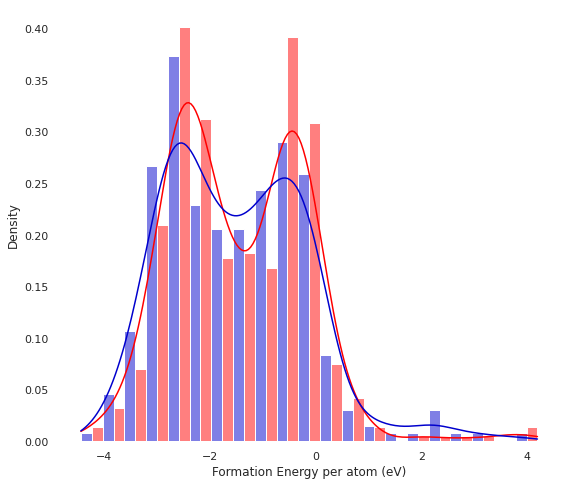

In [9]:
f, ax = plt.subplots(figsize=(9,8))
sns.histplot(data=df, x='e_form', hue='magic', multiple='dodge', 
             legend=False, common_norm=False, stat='density', kde=True)
sns.despine(left=True, bottom=True)
plt.xlabel('Formation Energy per atom (eV)')

In [10]:
X_raw=npzfile['X_raw']
y_raw=y_raw = np.array(df["e_form"]).reshape(-1, 1)
y_atom=npzfile['magic']
my_frames=npzfile['my_frames']

PRINCIPAL COVARIATES REGRESSION (PCovR) REPRESENTATION

In [11]:
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
    np.arange(X_raw.shape[0]), X_raw, y_raw, train_size=0.8
)
print(f'Shape of testing data is: {X_train.shape}, ||X|| = {np.linalg.norm(X_train)}.')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(
    "Norm of the features: %0.2f \nNorm of the targets: %0.2f"
    % (np.linalg.norm(X_raw), np.linalg.norm(y_raw))
)
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_raw)
y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_raw)

# Center total dataset
X = x_scaler.transform(X_raw)
Y = y_scaler.transform(y_raw)

# Center training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Center training data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

print("After normalization: ")
print(f'Shape of testing data is: {X_train.shape}, ||X|| = {np.linalg.norm(X_train)}.')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(
    "Norm of the features: %0.2f \nNorm of the targets: %0.2f"
    % (np.linalg.norm(X_raw), np.linalg.norm(y_raw))
)

Shape of testing data is: (672, 2000), ||X|| = 0.07684765891762216.
(672, 2000) (168, 2000) (672, 1) (168, 1)
Norm of the features: 0.08 
Norm of the targets: 56.70
After normalization: 
Shape of testing data is: (672, 2000), ||X|| = 26.500854968727314.
(672, 2000) (168, 2000) (672, 1) (168, 1)
Norm of the features: 0.08 
Norm of the targets: 56.70


GRID CV REGRESSION

R^2 of training is  0.1774200460615527
R^2 of testing is  -0.07294018837479554
Best regularization is  1.0
RMSE on predicted quantity =  1.0631938409370538


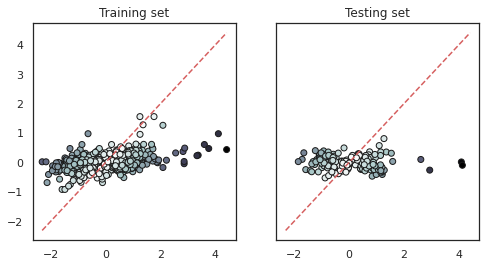

In [12]:
alphas=np.logspace(-0, -6, 30)
ridgecv = RidgeCV(cv=4,fit_intercept=False, alphas=alphas)
ridgecv.fit(X_train, y_train)
yp_test=ridgecv.predict(X_test)
yp_train=ridgecv.predict(X_train)
print('R^2 of training is ', ridgecv.score(X_train,y_train))
print('R^2 of testing is ', ridgecv.score(X_test,y_test))
print('Best regularization is ', ridgecv.alpha_)
fig, (ax_train, ax_test)=plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
ax_train.scatter(y_train, yp_train, c=np.abs(y_train - yp_train), cmap="bone_r", ec="k")
ax_test.scatter(y_test, yp_test, c=np.abs(y_test - yp_test), cmap="bone_r", ec="k")

bounds=(np.min((Y.min(), yp_train.min(), yp_test.min())), 
       np.max((Y.max(), yp_train.max(), yp_test.max()))
       )

ax_train.plot(bounds,bounds, 'r--')
ax_train.set_title('Training set')
ax_test.set_title('Testing set')
ax_test.plot(bounds,bounds, 'r--')


print("RMSE on predicted quantity = ", mean_squared_error(y_test, yp_test))


HOW MIXING PARAMETER BETA (BETWEEN PCA AND REGRESSION) AFFECTS PCOVR

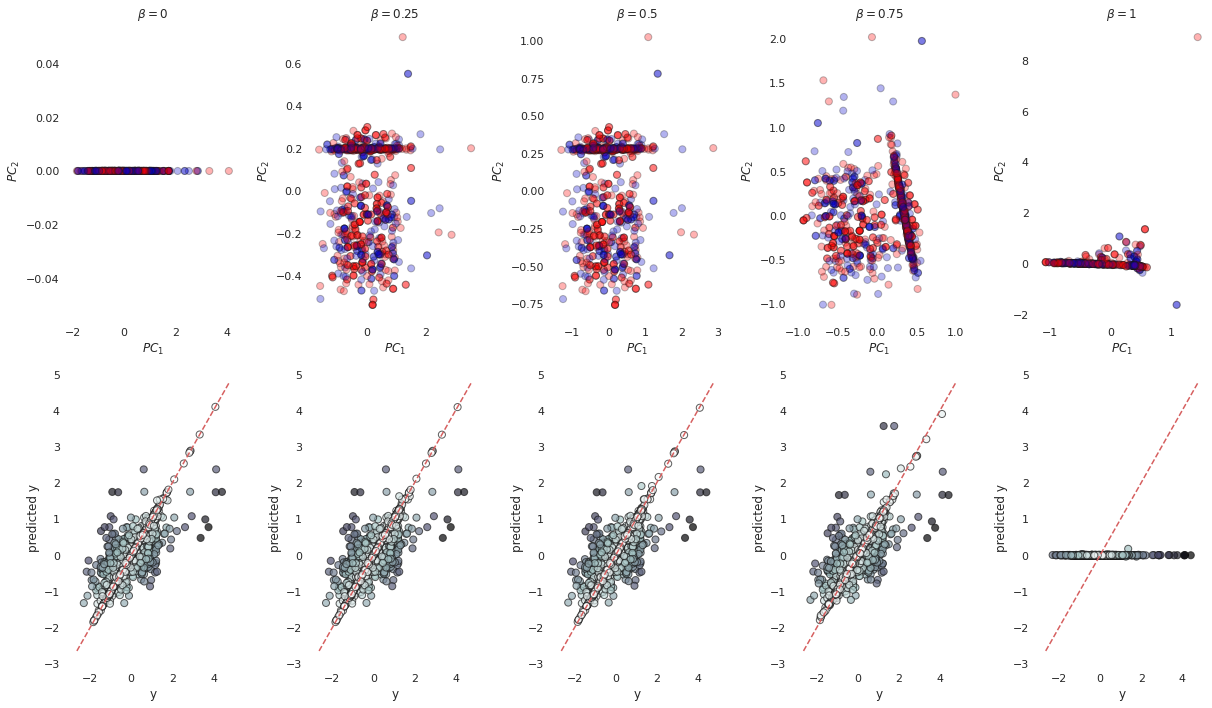

In [13]:

betas=[0,0.25, 0.5, 0.75, 1]

fig, axes = plt.subplots(2,5, figsize=(17,10))
sns.despine(left=True, bottom=True)

for i in range(len(betas)):
    
    pcovr = PCovR(mixing=betas[i],
              n_components=2)
    pcovr.fit(X,Y)
    T = pcovr.transform(X)
    yp = pcovr.predict(X)

    axes[0,i].scatter(T[:, 0], T[:, 1], s=50, alpha=0.3, c=y_atom, cmap = colors.ListedColormap(["mediumblue", 'red']), edgecolor="k")
    axes[0,i].set_xlabel(r"$PC_1$")
    axes[0,i].set_ylabel(r"$PC_2$")


    axes[1,i].scatter(Y, yp, s=50, alpha=0.7, c=np.abs(Y - yp), cmap='bone_r', edgecolor="k")
    axes[1,i].plot(axes[1,i].get_xlim(), axes[1,i].get_xlim(), 'r--')
    axes[1,i].set_xlabel(r"y")
    axes[1,i].set_ylabel(r"predicted y")


    axes[0,i].set_title(r"$\beta=$" + str(betas[i]))
    fig.tight_layout()

ENERGY DESCRIPTORS 

In [14]:
df.head()
e_form=df['e_form']
e_hull=df['e_hull']
e_gap=df['gap pbe']

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


R^2 with PCovR=  -0.8700689090621045
R^2 of testing is with RidgeCV -0.2675914561442181
RMSE on predicted quantity =  1.0808203083709018
error in units (eV) of predicted quantity before scaling =  [10.95016446]
error in units (eV) of predicted quantity after scaling=  [8.51809289]


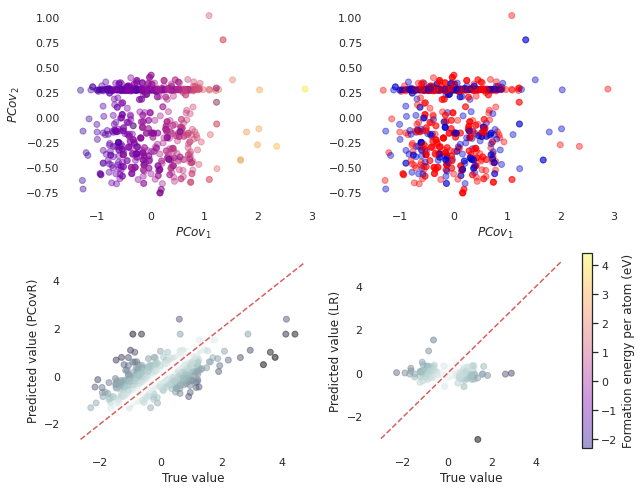

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


R^2 with PCovR=  -0.8270650415485323
R^2 of testing is with RidgeCV -0.04902658171288965
RMSE on predicted quantity =  0.7391794100216319
error in units (eV) of predicted quantity before scaling =  [6.18136969]
error in units (eV) of predicted quantity after scaling=  [12.376456]


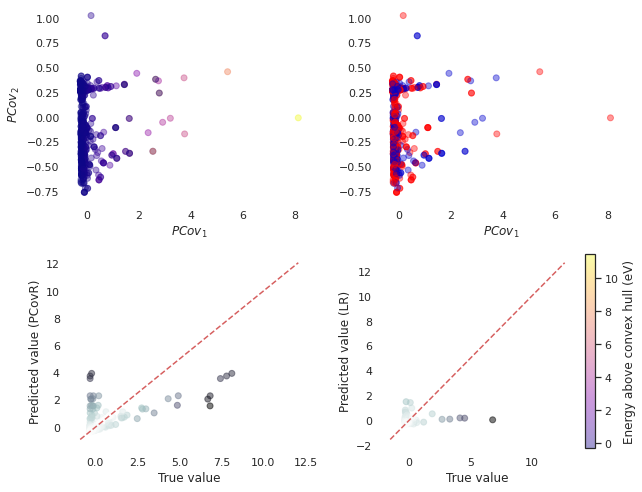

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


R^2 with PCovR=  -0.8140058822749574
R^2 of testing is with RidgeCV -0.13656239582312635
RMSE on predicted quantity =  0.8591893782022497
error in units (eV) of predicted quantity before scaling =  [8.65651383]
error in units (eV) of predicted quantity after scaling=  [5.33857179]


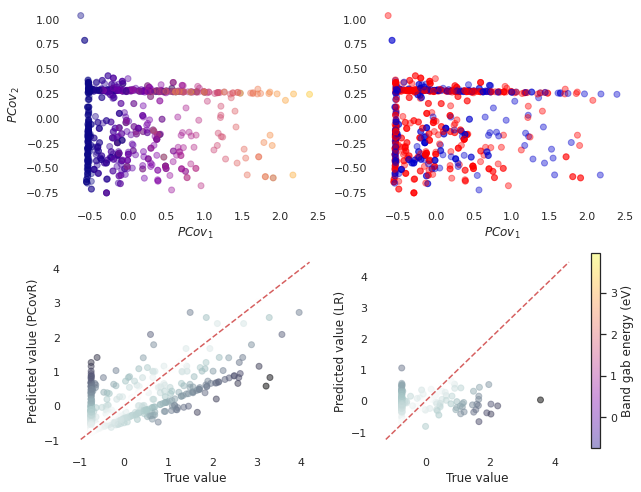

In [16]:
n_PC=5 #  number of principal covariates
titles=['Formation energy per atom (eV)', 'Energy above convex hull (eV)', 'Band gab energy (eV)']
quantity=[e_form, e_hull, e_gap]
for i in range(len(titles)):
    X=np.copy(X_raw)
    y_raw=np.array(quantity[i]).reshape(-1, 1)
    i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
    np.arange(X.shape[0]), X, y_raw, train_size=0.8
    )

    x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
    y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_raw)

    # Center total dataset
    X = x_scaler.transform(X)
    Y = y_scaler.transform(y_raw)

    # Center training data
    X_train = x_scaler.transform(X_train)
    y_train = y_scaler.transform(y_train)

    # Center training data
    X_test = x_scaler.transform(X_test)
    y_test = y_scaler.transform(y_test)
    pcovr = PCovR(mixing=0.5,
              n_components=n_PC)
    pcovr.fit(X,Y)
    
    T = pcovr.transform(X)
    yp = pcovr.predict(X)
    
    ridgecv.fit(X_train, y_train)
    yp_test=ridgecv.predict(X_test)
#     fig, ((caxT, caxM),(axT, axM),  (axy, axy_reg), (caxy, caxy_reg)) = plt.subplots(
#         4, 2, figsize=(9,9), gridspec_kw=dict(height_ratios=(0.07, 1, 1, 0.07)))
    fig, ((axT, axM),  (axy, axy_reg)) = plt.subplots(
        2, 2, figsize=(9,7))
    cax = fig.add_axes()
    
    scatT = axT.scatter(T[:, 0], T[:, 1], alpha=0.4, c=Y, cmap='plasma')
    axT.set_xlabel(r"$PCov_1$")
    axT.set_ylabel(r"$PCov_2$")
    fig.colorbar(scatT, cax=cax, orientation='vertical', label=titles[i])

#     fig.colorbar(scatT, cax=caxT, label=titles[i], orientation="horizontal")

    scatM = axM.scatter(T[:, 0], T[:, 1], alpha=0.4, c=y_atom, cmap = my_c)
    axM.set_xlabel(r"$PCov_1$")
#     fig.colorbar(scatM, cax=caxM, label="magic=1", orientation="horizontal")

    scaty = axy.scatter(Y, yp, alpha=0.5, c=np.abs(Y - yp), cmap='bone_r')
    axy.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
    axy.set_xlabel(r"True value")
    axy.set_ylabel(r"Predicted value (PCovR)")
#     fig.colorbar(scaty, cax=caxy,label='Error in y', orientation="horizontal")
    
    scaty_reg=axy_reg.scatter(y_test, yp_test, c=np.abs(y_test - yp_test), cmap="bone_r", alpha=0.5)    
    axy_reg.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
    axy_reg.set_xlabel(r"True value")
    axy_reg.set_ylabel(r"Predicted value (LR)")
#     fig.colorbar(scaty_reg, cax=caxy_reg,label='Error in y', orientation="horizontal")
    
    fig.tight_layout()
    sns.despine(left=True, bottom=True)
    print('R^2 with PCovR= ', pcovr.score(X,Y))
    print('R^2 of testing is with RidgeCV', ridgecv.score(X_test,y_test))
    print("RMSE on predicted quantity = ", mean_squared_error(y_test, yp_test))
    print("error in units (eV) of predicted quantity before scaling = ", (max(y_raw)-min(y_raw))*(1-ridgecv.score(X_test,y_test)))
    print("error in units (eV) of predicted quantity after scaling= ", (max(Y)-min(Y))*(1-ridgecv.score(X_test,y_test)))

    plt.show()
    plt.close()